# Install Dependencies


In [2]:
!pip install tensorflow==2.15.0 keras==2.15 tensorflow-hub==0.13.0 tensorflow-text==2.15.0
!pip install datasets
!pip -q install evaluate
!pip install imbalanced-learn
!pip install transformers datasets scikit-learn imbalanced-learn evaluate

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.15.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


# Import Libraries

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.layers import Input
import numpy as np


import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



# Tensor Flow

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Check if libraries are installed and print their versions
try:
    print(f"TensorFlow Hub Version: {hub.__version__}")
except ImportError:
    print("TensorFlow Hub is not installed.")

try:
    print(f"TensorFlow Text Version: {text.__version__}")
except ImportError:
    print("TensorFlow Text is not installed.")

try:
    print(f"TensorFlow Version: {tf.__version__}")
except ImportError:
    print("TensorFlow is not installed.")

try:
    print(f"pandas Version: {pd.__version__}")
except ImportError:
    print("pandas is not installed.")

try:
    print(f"scikit-learn Version: {train_test_split.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

try:
    print(f"scikit-learn Version: {classification_report.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

#other usefull

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler


# Import Libraries

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict



TensorFlow Hub Version: 0.16.1
TensorFlow Text Version: 2.17.0
TensorFlow Version: 2.17.1
pandas Version: 2.2.2
scikit-learn Version: sklearn
scikit-learn Version: sklearn


# Import Github

In [7]:
!git clone https://github.com/tajuar-akash-hub/Datasets.git

Cloning into 'Datasets'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 3.87 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (11/11), done.


# Dataset Location

In [13]:
my_df_loc = '/kaggle/working/Datasets/generated_with_gemini.csv'

# BERT Variations


## DistilBERT

In [9]:
pip install --upgrade sympy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 70.1 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Load the Dataset
data = pd.read_csv(my_df_loc)
data.dropna(inplace=True)
data = data[['Generated_using_gemini', 'fraud_status']]
data['fraud_status'] = data['fraud_status'].astype(int)

In [15]:
# Train-Test Split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['fraud_status'], random_state=42)


In [16]:
# Oversampling on Training Data Only
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    train_data[['Generated_using_gemini']], train_data['fraud_status']
)

In [17]:
# Combine Resampled Training Data
train_data_resampled = pd.DataFrame({
    'Generated_using_gemini': X_train_resampled['Generated_using_gemini'].values,
    'fraud_status': y_train_resampled.values
})

In [18]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [19]:
def tokenize_function(data):
    return tokenizer(
        data['Generated_using_gemini'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='np'
    )


In [20]:
train_encodings = tokenize_function(train_data_resampled)
test_encodings = tokenize_function(test_data)


In [22]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_data_resampled['fraud_status'].values
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_data['fraud_status'].values
})


In [23]:
# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Define Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1": f1_score(labels, predictions, average="weighted"),
        "mcc": matthews_corrcoef(labels, predictions)
    }

In [25]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./distilbert-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-26-90c4f5e7af86>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
# Train the Model

trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc
1,No log,0.236280,0.930328,0.899146,0.930328,0.910977,0.101326
2,No log,0.333652,0.937158,0.910501,0.937158,0.915043,0.150171
3,0.208400,0.390103,0.937158,0.910501,0.937158,0.915043,0.150171
4,0.208400,0.420461,0.938525,0.914967,0.938525,0.915868,0.165969
5,0.208400,0.430505,0.938525,0.914967,0.938525,0.915868,0.165969


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=860, training_loss=0.12327802513920984, metrics={'train_runtime': 814.4694, 'train_samples_per_second': 33.691, 'train_steps_per_second': 1.056, 'total_flos': 3634905419120640.0, 'train_loss': 0.12327802513920984, 'epoch': 5.0})

In [28]:
# Evaluate the Model

results = trainer.evaluate()
print("Evaluation Results:", results)


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.4204608201980591, 'eval_accuracy': 0.9385245901639344, 'eval_precision': 0.9149674840807479, 'eval_recall': 0.9385245901639344, 'eval_f1': 0.9158676731630313, 'eval_mcc': 0.16596928453554677, 'eval_runtime': 7.2434, 'eval_samples_per_second': 101.057, 'eval_steps_per_second': 3.175, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


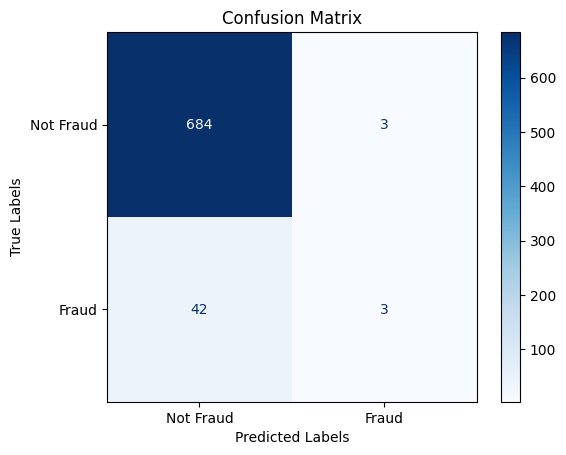

In [29]:
# Generate Metrics for Confusion Matrix and ROC Curve
predictions = trainer.predict(test_dataset)
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)
predicted_probabilities = predictions.predictions[:, 1]  # Positive class probabilities


# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



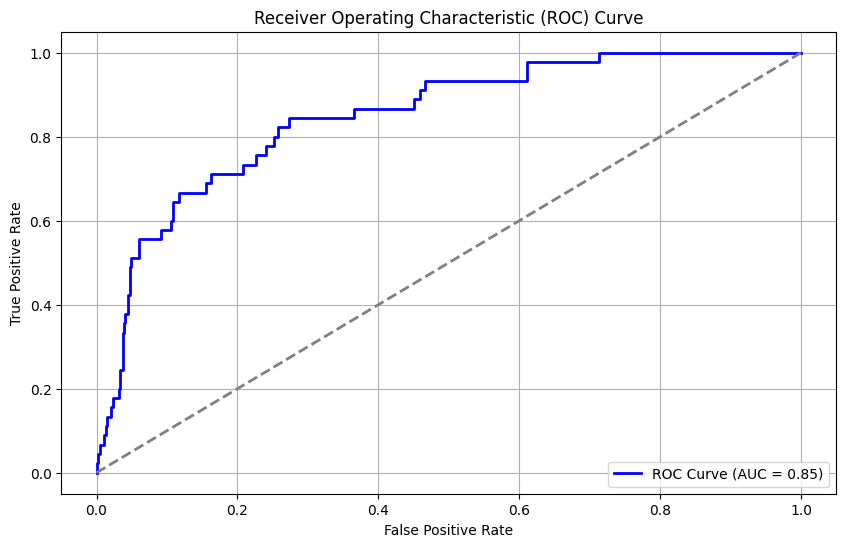

In [30]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [31]:
# Training and Validation Loss Curves
train_logs = trainer.state.log_history
train_loss = [log['loss'] for log in train_logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]


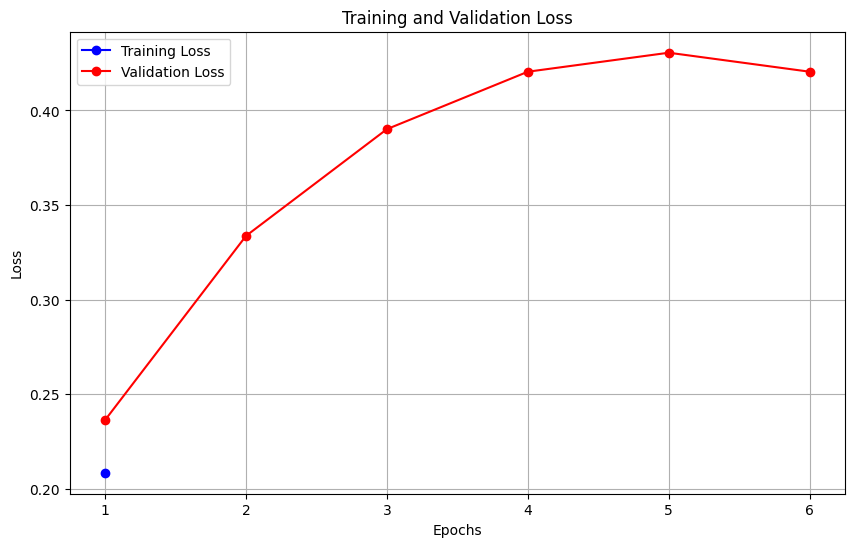

In [32]:
# Plot Training and Validation Loss

plt.figure(figsize=(10, 6))
epochs_train = range(1, len(train_loss) + 1)
epochs_val = range(1, len(val_loss) + 1)
plt.plot(epochs_train, train_loss, marker='o', label='Training Loss', color='b')
plt.plot(epochs_val, val_loss, marker='o', label='Validation Loss', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()